



Built using guidance from https://arxiv.org/pdf/1512.09300.pdf

Features:
  * Uses ELU activations
  * Deconvolution uses upscaling unpool layer before affine operator, rather than spacing with zeros
  * Batch normalization after each transformation
  * Dropout layer after activation
  * abs-sum image loss rather than cross-entropy loss

# Summary

Best result so far is 10 epochs of the first training batch, with the prior and the prediction weighted equally.

Running another 10 epochs doesn't hurt the similarity results, but it does make the reconstructions worse.

Not quite as good after 10 epochs with regularization=0.1 (down-weighted prior)

In [7]:
import tensorflow as tf
 
print("running TensorFlow version {}".format(tf.__version__))

running TensorFlow version 1.8.0-dev20180330


In [8]:
# Control memory usage

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [9]:
# Report OOM details

run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)


# Import data

In [10]:
DATA_ROOT = '../../data/'

In [11]:
import os
import re

from operator import itemgetter

In [12]:
train_256_pattern = re.compile('^train_(?P<block_id>[0-9]{3})_256x256\.tfrecords')
validate_256_pattern = re.compile('^validate_(?P<block_id>[0-9]{3})_256x256\.tfrecords')

In [13]:
TFRECORDS_DIR = os.path.join(DATA_ROOT, 'tfrecords_alt')

ALL_TFRECORDS = os.listdir(TFRECORDS_DIR)

def get_sorted_records(pattern, directory):
     return [ \
         os.path.join(directory, _file) \
         for _file in \
         sorted([_m[0] for _m in \
             [pattern.match(_f) for _f in os.listdir(directory)] if _m]) \
     ]

TRAIN_TFRECORDS = get_sorted_records(train_256_pattern, TFRECORDS_DIR)
VALIDATE_TFRECORDS = get_sorted_records(validate_256_pattern, TFRECORDS_DIR)

In [14]:
TRAIN_TFRECORDS, VALIDATE_TFRECORDS

(['../../data/tfrecords_alt/train_003_256x256.tfrecords'],
 ['../../data/tfrecords_alt/validate_003_256x256.tfrecords'])

In [15]:
RUN_NAME = 'vae/vae_08'
SUMMARY_DIR = os.path.join(DATA_ROOT, 'logs', RUN_NAME)
MODEL_DIR = os.path.join(DATA_ROOT, 'models', RUN_NAME)
MODEL_GRAPH = os.path.join(MODEL_DIR, 'vae.meta')
MODEL_PREFIX = os.path.join(MODEL_DIR, 'vae')
VIS_DIR = os.path.join(SUMMARY_DIR,'vis')
SPRITE_DIR = os.path.join(VIS_DIR, 'sprite.png')
META_DIR =  os.path.join(VIS_DIR, 'metadata.tsv')

In [16]:
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUMMARY_DIR, exist_ok=True)

In [17]:
def _decode(serialized_example):
    '''Parses an image and label from the given `serialized_example`
    '''
    features = tf.parse_single_example(
        serialized_example,
        features={
            'filename': tf.FixedLenFeature([], tf.string),
            'image': tf.FixedLenFeature([], tf.string),
            'view': tf.FixedLenFeature([], tf.string),
            'gender': tf.FixedLenFeature([], tf.string),
            'age': tf.FixedLenFeature([], tf.int64),
            'labels': tf.FixedLenSequenceFeature( [], dtype=tf.int64, default_value=-1,allow_missing=True)
            })
       

    # Convert from a scalar string tensor
    filename = tf.cast(features['filename'], tf.string)
    image = tf.decode_raw(features['image'], tf.float32)
    view = tf.cast(features['view'], tf.string)
    gender = tf.cast(features['gender'], tf.string)
    age = tf.cast(features['age'], tf.int32)
    labels = tf.cast(features['labels'], tf.int32)
    
    return filename, image, view, gender, age, labels


def _augment(filename, image, view, gender, age, labels):
    '''Placeholder for data augmentation
    '''
    image = tf.reshape(image, [256, 256, 1])
    return filename, image, view, gender, age, labels


def _normalize(filename, image, view, gender, age, labels):
    '''Convert `image` from [0, 255] -> [-0.5, 0.5] floats
    '''
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
    return filename, image, view, gender, age, labels

In [18]:
def inputs(filenames, batch_size, num_epochs):
    ''' Reads input data num_epochs times or forever if num_epochs is None
        returns dataset, iterator pair
    '''

    with tf.name_scope('input'):
        # TFRecordDataset opens a binary file and reads one record at a time.
        # `filename` could also be a list of filenames, which will be read in order.
        dataset = tf.data.TFRecordDataset(filenames)

        # The map transformation takes a function and applies it to every element
        # of the dataset.
        dataset = dataset.map(_decode)
        dataset = dataset.map(_augment)
        dataset = dataset.map(_normalize)

        # The shuffle transformation uses a finite-sized buffer to shuffle elements
        # in memory. The parameter is the number of elements in the buffer. For
        # completely uniform shuffling, set the parameter to be the same as the
        # number of elements in the dataset.
        dataset = dataset.shuffle(1000 + 3 * batch_size)

        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(batch_size)

        iterator = dataset.make_one_shot_iterator()

    return dataset, iterator

# VAE Model

In [19]:
# training parameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 5

DROPOUT = 0.7
REGULARIZATION = 0.1

DISPLAY_EVERY = 100

## Loggers

In [20]:
def variable_summary(x, name):
    with tf.variable_scope(name):
        mean = tf.reduce_mean(x)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(x - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(x))
        tf.summary.scalar('min', tf.reduce_min(x))
        tf.summary.histogram('histogram', x)

## Component layers

In [21]:
# unpool operation doesn't yet exist in TF

def unpool_op(x, stride, name='unpool'):

    with tf.name_scope(name) as scope:

        if stride==1:
            return x

        shape = x.get_shape().as_list()
        dim = len(shape[1:-1])
        out = (tf.reshape(x, [-1] + shape[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out]*stride, i)
        out_size = [-1] + [s * stride for s in shape[1:-1]] + [shape[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [22]:
def convolution_layer(x, dims, stride, train, bias=None, name='conv', activation=tf.nn.elu):

    with tf.variable_scope(name):

        # Parameters
        weights = tf.get_variable('w', dims,
                    initializer=tf.contrib.layers.xavier_initializer())

        if bias is not None:
            biases = tf.get_variable('b', [dims[-1]],
                        initializer=tf.random_normal_initializer())

        # Layer structure
        if bias is None:
             conv = tf.nn.conv2d(x, weights, strides=[1, stride, stride, 1], padding='SAME', name='conv')
        else:
             conv = tf.nn.bias_add(tf.nn.conv2d(x, weights, strides=[1, stride, stride, 1],
                        padding='SAME'), biases, name='conv')
        normalized = tf.layers.batch_normalization(conv, axis=3, training=train,
                    name='spatial_batch_norm')        
        activations = activation(normalized, name='activation')
        activations = tf.layers.dropout(activations, rate=DROPOUT, training=train, name='dropout')

        # Variable summaries
        variable_summary(weights, 'weights')
        if bias is not None:
            variable_summary(biases, 'biases')
        tf.summary.histogram('pre-activations', normalized)
        tf.summary.histogram('activations', activations)

        return activations

In [23]:
def deconvolution_layer(x, dims, stride, train, bias=None, name='deconv', activation=tf.nn.elu):

    with tf.variable_scope(name):

        # Parameters
        weights = tf.get_variable('w', dims,
                    initializer=tf.contrib.layers.xavier_initializer())
        if bias is not None:
            biases = tf.get_variable('b', [dims[-1]],
                        initializer=tf.random_normal_initializer())

        # Layer structure
        unpool = unpool_op(x, stride, name='unpool')
        if bias is None:
            deconv = tf.nn.conv2d(unpool, weights, strides=[1, 1, 1, 1], padding='SAME', name='deconv')
        else:
            deconv = tf.nn.bias_add(tf.nn.conv2d(unpool, weights, strides=[1, 1, 1, 1],
                        padding='SAME'), biases, name='deconv')
        normalized = tf.layers.batch_normalization(deconv, axis=3, training=train,
                    name='spatial_batch_norm')        
        activations = activation(deconv, name='activation')
        activations = tf.layers.dropout(activations, rate=DROPOUT, training=train, name='dropout')

        # Variable summaries
        variable_summary(weights, 'weights')
        if bias is not None:
            variable_summary(biases, 'biases')
        tf.summary.histogram('pre-activations', deconv)
        tf.summary.histogram('activations', activations)

        return activations

In [24]:
def dense_layer(x, dims, train, bias=None, name='fc', activation=tf.nn.elu):

    with tf.variable_scope(name):

        # Parameters
        weights = tf.get_variable('w', dims,
                    initializer=tf.contrib.layers.xavier_initializer())
        if bias is not None:
            biases = tf.get_variable('b', [dims[-1]],
                        initializer=tf.random_normal_initializer())

        # Layer structure
        if bias is None:
            dense = tf.matmul(x, weights, name='dense')
        else:
            dense = tf.nn.bias_add(tf.matmul(x, weights), biases, name='dense')

        normalized = tf.layers.batch_normalization(dense, axis=1, training=train,
                    name='batch_norm')
        activations = activation(normalized, name='activation')

        # Variable summaries
        variable_summary(weights, 'weights')
        if bias is not None:
            variable_summary(biases, 'biases')
        tf.summary.histogram('pre-activations', normalized)
        tf.summary.histogram('activations', activations)

        return activations

In [25]:
def gaussian_sample(mean, stddev, name):

    with tf.variable_scope(name):

        # mean is unconstrained; stddev must be strictly positive
        stddev = 1e-6 + tf.nn.softplus(stddev)

        # actually sample
        z = mean + stddev * tf.random_normal(tf.shape(mean), 0, 1, dtype=tf.float32)

        # Variable summaries
        tf.summary.histogram('mean', mean)
        tf.summary.histogram('stddev', stddev)
        tf.summary.histogram('z', z)

        return mean, stddev, z

## Loss

In [26]:
def evaluate(x, xhat, mu, sigma):

    with tf.variable_scope('loss'):
        # Structure
        pred = tf.losses.absolute_difference(x, xhat,
                reduction=tf.losses.Reduction.MEAN)

        # offsetx = x + 0.5
        # pred = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        #         labels=offsetx, logits=xhat))

        KLdiv = 0.5 * tf.reduce_mean(tf.square(mu) + \
                    tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1)

        loss = tf.add(REGULARIZATION * KLdiv, pred)

        # Summaries
        tf.summary.scalar('prediction', pred)
        tf.summary.scalar('prior', KLdiv)
        tf.summary.scalar('loss', loss)

    return loss, pred, KLdiv

## Autoencoder

In [27]:
def encoder(img, train):

    with tf.variable_scope('encoder'):

        # convolution
        conv1 = convolution_layer(img, [5, 5, 1, 64], 2, train, name='conv1')
        conv2 = convolution_layer(conv1, [5, 5, 64, 128], 2, train, name='conv2')
        conv3 = convolution_layer(conv2, [5, 5, 128, 256], 2, train, name='conv3')

        # transition
        conv3 = tf.reshape(conv3, [-1, 32*32*256], name='reshape1')

        # dense output
        fc1 = dense_layer(conv3, [32*32*256, 256], train,
                activation=tf.identity, name='fc1')

        # sample
        mu, sigma, z = gaussian_sample(fc1[:, :128], fc1[:, 128:], name='output')

    return mu, sigma, z

In [28]:
def decoder(z, train):

    with tf.variable_scope('decoder'):

        # dense input
        fc1 = dense_layer(z, [128, 32*32*256], train, name='fc1')

        # transition
        fc1 = tf.reshape(fc1, [-1, 32, 32, 256], name='reshape1')

        # deconvolution
        deconv1 = deconvolution_layer(fc1, [5, 5, 256, 128], 2, train,
                            name='deconv1')
        deconv2 = deconvolution_layer(deconv1, [5, 5, 128, 64], 2, train, 
                            name='deconv2')
        deconv3 = deconvolution_layer(deconv2, [5, 5, 64, 32], 2, train,
                            name='deconv3')
        logits = deconvolution_layer(deconv3, [5, 5, 32, 1], 1, train,
                            activation=tf.identity, name='logits')

        # put into image range for display
        with tf.name_scope('range'):
            xhat = 0.5 * tf.nn.tanh(logits)

    return xhat, logits

# Build and run

## Initialize

In [29]:
import sys
import os
import argparse
from datetime import datetime

import logging
logging.basicConfig(
    datefmt="%Y-%m-%dT%H:%M:%S%z",
    format="%(asctime)s [train/initialize] %(levelname)-8s %(message)s",
    level=logging.INFO
)

NOW_STR = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S%z")
RUN_DESC = "cross-entropy loss, 256x256 images, no bias"
RANDOM_SEED = 42


In [30]:


def initialize():

    logging.info("initializing run: {}".format(RUN_NAME))

    # write a note regarding this run
    os.makedirs(SUMMARY_DIR, exist_ok=True)
    with open(os.path.join(SUMMARY_DIR, "description.txt"), 'w') as fh:
        fh.write(NOW_STR+" "+RUN_DESC)

    # Control memory usage
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    # Report OOM details
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)

    # Build graph
    with tf.Graph().as_default() as graph:

        # Repeatable results
        tf.set_random_seed(RANDOM_SEED)

        # Get Data
        train_dataset, train_iterator = inputs(filenames=TRAIN_TFRECORDS,
                batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS)

        # Data placeholder
        data_handle = tf.placeholder(tf.string, shape=[])
        iterator = tf.data.Iterator.from_string_handle(
            data_handle, train_dataset.output_types, train_dataset.output_shapes)
        
       

        filename, images, view, gender, age, labels = iterator.get_next()

        # Train/validate flag
        train = tf.placeholder(tf.bool)

        # Global counter
        global_step = tf.train.get_or_create_global_step(graph)

        # Dropout
        dropout = tf.placeholder(tf.float32)

        # Autoencoder
        mu, sigma, z = encoder(images, train)
        xhat, logits = decoder(z, train)
        loss, recon, reg = evaluate(images, xhat, mu, sigma)

        # Training branch - control dependencies so batchnorm params are updated
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)\
                .minimize(loss, global_step=global_step, name='optimizer')

        # Log output for Tensorboard
        merged = tf.summary.merge_all()
        train_summary_logger = tf.summary.FileWriter(SUMMARY_DIR+'/train',
                        graph=graph, flush_secs=30)

        # Initializer
        init_variables = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        # Save state
        tf.add_to_collection('optimizer', optimizer)

        tf.add_to_collection('filename', filename)
        tf.add_to_collection('images', images)
        tf.add_to_collection('view', view)

        tf.add_to_collection('gender', gender)
        tf.add_to_collection('age', age)
        tf.add_to_collection('labels', labels)
        
        tf.add_to_collection('mu', mu)
        
        tf.add_to_collection('sigma', sigma)
        tf.add_to_collection('xhat', xhat)

        tf.add_to_collection('loss', loss)
        tf.add_to_collection('recon', recon)
        tf.add_to_collection('reg', reg)

        tf.add_to_collection('data_handle', data_handle)
        tf.add_to_collection('train', train)

        tf.add_to_collection('merged', merged)

        writer = tf.train.Saver()

        # Run one step: this initializes the graph and saves our starting statistics
        with tf.Session(config=config) as session:

            session.run(init_variables)

            train_handle = session.run(train_iterator.string_handle())

            # Output header
            logging.info("  step      loss      recon     reg")

            _, step = session.run([optimizer, global_step],
                    feed_dict = { data_handle: train_handle, train: 1 },
                    options = run_options)

            loss_, recon_, reg_, summary = \
                session.run([loss, recon, reg, merged],
                           feed_dict = { data_handle: train_handle, train: 0 })
            train_summary_logger.add_summary(summary, step)

            logging.info("{: 6d} {:9.3g} {:9.3g} {:9.3g}".format(step, loss_, recon_, reg_))

            # Save graph
            logging.info("saving graph")
            writer.save(session, MODEL_PREFIX, global_step=step, write_meta_graph=False)
            writer.export_meta_graph(MODEL_GRAPH)
            


def main():

    parser = argparse.ArgumentParser(description='initialize training graph')
    initialize()
    sys.exit(0)


if __name__ == '__main__':
    main()

2018-06-07T17:00:49+0000 [train/initialize] INFO     initializing run: vae/vae_08
2018-06-07T17:00:56+0000 [train/initialize] INFO       step      loss      recon     reg


ResourceExhaustedError: OOM when allocating tensor with shape[32,128,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: encoder/conv1/dropout/cond/dropout/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=42, seed2=110, _device="/job:localhost/replica:0/task:0/device:GPU:0"](encoder/conv1/dropout/cond/dropout/Shape-0-0-VecPermuteNCHWToNHWC-LayoutOptimizer/_11)]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  128.00MiB from encoder/conv1/spatial_batch_norm/cond/FusedBatchNorm
  128.00MiB from encoder/conv1/conv
  128.00MiB from encoder/conv1/dropout/cond/dropout/div
  Remaining 1 nodes with 256B

	 [[Node: decoder/fc1/batch_norm/cond_3/Merge/_84 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_805_decoder/fc1/batch_norm/cond_3/Merge", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  128.00MiB from encoder/conv1/spatial_batch_norm/cond/FusedBatchNorm
  128.00MiB from encoder/conv1/conv
  128.00MiB from encoder/conv1/dropout/cond/dropout/div
  Remaining 1 nodes with 256B


Caused by op 'encoder/conv1/dropout/cond/dropout/random_uniform/RandomUniform', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-7a16705582b6>", line 127, in <module>
    main()
  File "<ipython-input-30-7a16705582b6>", line 122, in main
    initialize()
  File "<ipython-input-30-7a16705582b6>", line 48, in initialize
    mu, sigma, z = encoder(images, train)
  File "<ipython-input-27-6db4fb288e6f>", line 6, in encoder
    conv1 = convolution_layer(img, [5, 5, 1, 64], 2, train, name='conv1')
  File "<ipython-input-22-7cac07ac1ea6>", line 22, in convolution_layer
    activations = tf.layers.dropout(activations, rate=DROPOUT, training=train, name='dropout')
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 351, in dropout
    return layer.apply(inputs, training=training)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 827, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 716, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 306, in call
    lambda: array_ops.identity(inputs))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/utils.py", line 206, in smart_cond
    pred, true_fn=true_fn, false_fn=false_fn, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/smart_cond.py", line 60, in smart_cond
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2053, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1903, in BuildCondBranch
    original_result = fn()
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 303, in dropped_inputs
    seed=self.seed)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 2316, in dropout
    noise_shape, seed=seed, dtype=x.dtype)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 672, in random_uniform
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3327, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1674, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,128,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: encoder/conv1/dropout/cond/dropout/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=42, seed2=110, _device="/job:localhost/replica:0/task:0/device:GPU:0"](encoder/conv1/dropout/cond/dropout/Shape-0-0-VecPermuteNCHWToNHWC-LayoutOptimizer/_11)]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  128.00MiB from encoder/conv1/spatial_batch_norm/cond/FusedBatchNorm
  128.00MiB from encoder/conv1/conv
  128.00MiB from encoder/conv1/dropout/cond/dropout/div
  Remaining 1 nodes with 256B

	 [[Node: decoder/fc1/batch_norm/cond_3/Merge/_84 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_805_decoder/fc1/batch_norm/cond_3/Merge", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Current usage from device: /job:localhost/replica:0/task:0/device:GPU:0, allocator: GPU_0_bfc
  128.00MiB from encoder/conv1/spatial_batch_norm/cond/FusedBatchNorm
  128.00MiB from encoder/conv1/conv
  128.00MiB from encoder/conv1/dropout/cond/dropout/div
  Remaining 1 nodes with 256B



## Train

In [58]:
with tf.Graph().as_default() as graph:
    
    # Repeatable results
    tf.set_random_seed(0)

    # Get Data
    _, train_iterator = inputs(filenames=TRAIN_TFRECORDS, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS)
        
    # Log output for Tensorboard
    train_summary_logger = tf.summary.FileWriter(SUMMARY_DIR+'/train', flush_secs=30)

    # Run
    with tf.Session(config=config) as session:

        # restore
        reader = tf.train.import_meta_graph(MODEL_GRAPH)
        reader.restore(session, tf.train.latest_checkpoint(MODEL_DIR))

        # must be called after reader so that the graph is populated
        writer = tf.train.Saver()

        # get references to graph endpoints
        global_step = tf.train.get_global_step(graph)

        optimizer = tf.get_collection('optimizer')[0]
        loss = tf.get_collection('loss')[0]
        recon = tf.get_collection('recon')[0]
        reg = tf.get_collection('reg')[0]

        data_handle = tf.get_collection('data_handle')[0]
        train = tf.get_collection('train')[0]

        merged = tf.get_collection('merged')[0]

        train_handle = session.run(train_iterator.string_handle())

        # Output header
        logging.info("  step      loss      recon     reg")

        while True:
            try:
                _, step = session.run([optimizer, global_step], 
                            feed_dict = { data_handle: train_handle, train: 1 })

                if not step%DISPLAY_EVERY:

                    loss_, recon_, reg_, summary = session.run([loss, recon, reg, merged],
                            feed_dict = { data_handle: train_handle, train: 0 })
                    train_summary_logger.add_summary(summary, step)

                    logging.info("{: 6d} {:9.3g} {:9.3g} {:9.3g}".format(
                        step, loss_, recon_, reg_))

                    writer.save(session, MODEL_PREFIX, global_step=step, write_meta_graph=False)

            except tf.errors.OutOfRangeError:
                break

INFO:tensorflow:Restoring parameters from ../../data/models/vae/vae_08/vae-0


2018-06-06T19:51:23+0000 [train/initialize] INFO     Restoring parameters from ../../data/models/vae/vae_08/vae-0
2018-06-06T19:51:24+0000 [train/initialize] INFO       step      loss      recon     reg
2018-06-06T19:52:07+0000 [train/initialize] INFO        100     0.362      0.34     0.217
2018-06-06T19:53:02+0000 [train/initialize] INFO        200     0.375     0.345     0.295
2018-06-06T19:53:58+0000 [train/initialize] INFO        300     0.355     0.326     0.289
2018-06-06T19:54:53+0000 [train/initialize] INFO        400     0.364     0.327     0.368


# Test

Try out the autoencoder by running it on some test set samples.

For a collection of test images:

1. Create (image, label, mu, sigma) tuples
1. For a seed image, compute the 10 nearest images using (mu, sigma)
1. View the nearby images and their labels, comparing them to the seed image

If the VAE has worked as expected, we should find that the nearby images match the seed visually, and perhaps even match according to their labels.

## Generate document vectors

In [6]:
# Store the documents
documents = []

def extend(docs, m, s, xh, f, i, v, a, g, l):
    start_id = len(docs)
    docs.extend([
        {
            'filename':f_.decode('ascii') ,
            'id_': k + start_id,
            'image': i_.reshape(256, 256)+0.5,
            'view': v_.decode('ascii') ,
            'age': a_,
            'gender': g_.decode('ascii'),
            'labels': l_,
            'sigma': s_,
            'mu': m_,
            'xhat': y_.reshape(256, 256)+0.5
        }
        for k, (m_, s_, y_, f_, i_, v_, a_, g_, l_) in enumerate(zip(m, s, xh, f, i, v, a, g, l))
    ])
    return docs

with tf.Graph().as_default() as graph:
    
    # Repeatable results
    tf.set_random_seed(0)

    # Get Data
    _, validate_iterator = inputs(filenames=VALIDATE_TFRECORDS, batch_size=BATCH_SIZE, num_epochs=1)
        
    # Log output for Tensorboard
    validate_summary_logger = tf.summary.FileWriter(SUMMARY_DIR+'/validate', flush_secs=30)

    # Run
    with tf.Session(config=config) as session:

        # restore
        reader = tf.train.import_meta_graph(MODEL_GRAPH)
        reader.restore(session, tf.train.latest_checkpoint(MODEL_DIR))
        
        # get references to graph endpoints
        filename = tf.get_collection('filename')[0]
        images = tf.get_collection('images')[0]
        view = tf.get_collection('view')[0]
        age = tf.get_collection('age')[0]
        gender = tf.get_collection('gender')[0]
        labels = tf.get_collection('labels')[0]

        mu = tf.get_collection('mu')[0]
        sigma = tf.get_collection('sigma')[0]
        xhat = tf.get_collection('xhat')[0]
        
        merged = tf.get_collection('merged')[0]
        
        data_handle = tf.get_collection('data_handle')[0]
        train = tf.get_collection('train')[0]

        validate_handle = session.run(validate_iterator.string_handle())
        
        step = 0
        while True:
            try:
                mu_, sigma_, xhat_, filename_, images_, view_, age_, gender_, labels_, summary = \
                    session.run([mu, sigma, xhat, filename, images, view,  age, gender, labels, merged],
                            feed_dict = { data_handle: validate_handle, train: 0 })
                
                documents = extend(documents, mu_, sigma_, xhat_, filename_, images_, view_, age_, gender_, labels_)
                
                step += 1
                validate_summary_logger.add_summary(summary, step)                        
                print("{}.".format(step), end="", flush=True)
                    
            except tf.errors.OutOfRangeError:
                print(".done")
                break

NameError: name 'tf' is not defined

## Examine images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heapq

%matplotlib inline

In [2]:
def show_image(img):
    plt.imshow(img,  cmap='gray')
    plt.show()

In [3]:
from collections import OrderedDict
LABEL_KEYS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "No Finding",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
]

label_keys_by_id = LABEL_KEYS
ids_by_label_key = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id)])
  
def getlabels(doc):
    list = []
    for index_value, index in enumerate(doc['labels']):
        if(index == 1):
            list.append(ids_by_label_key.get(index_value))

    return list

In [4]:
from collections import OrderedDict
LABEL_KEYS_SHORT = [
    "Ats",
    "Ca",
    "Co",
    "Ed",
    "Ef",
    "Em",
    "Fi",
    "He",
    "In",
    "Ma",
    "No",
    "No",
    "Pl",
    "Pn",
    "Px"
]

label_keys_by_id2 = LABEL_KEYS_SHORT
ids_by_label_key2 = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id2)])

def getlabels_short(doc):
    list = []
    for index_value, index in enumerate(doc['labels']):
        if(index == 1):
            list.append(ids_by_label_key2.get(index_value)[:2])
            
    return list

NameError: name 'documents' is not defined

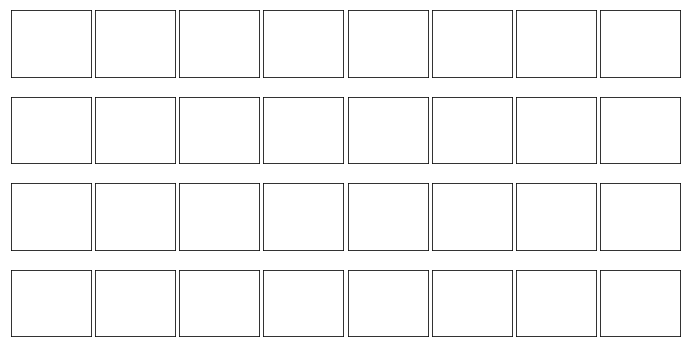

In [5]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, doc in zip(axes.flat, documents[32:64]):
    ax.set_title("image {}".format(doc['id_']))
    ax.imshow(doc['image'])
    
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, doc in zip(axes.flat, documents[:32]):
    ax.set_title("repro {}".format(doc['id_']))
    ax.imshow(doc['xhat'])
    
plt.show()

## Do some example searches

### KL divergence-based distance

In [ ]:
def kl(xbar, xsigma, ybar, ysigma):
    ''' KL(x||y)
    '''
    xvar = xsigma**2
    yvar = ysigma**2
    
    return 0.5*np.sum((xvar+(xbar-ybar)**2)/yvar - 1 + np.log(yvar/xvar))

In [ ]:
kl_matrix = np.zeros((len(documents), len(documents)))

for k, d1 in enumerate(documents):
    for d2 in documents:
        kl_matrix[d1['id_'], d2['id_']] = kl(d2['mu'], d2['sigma'], d1['mu'], d1['sigma'])
    if not (k+1)%24:
        print('.', end='', flush=True)
print('done')

In [ ]:
for seed in documents[:4]:
    def score(doc):
        if doc['id_'] == seed['id_']:
            return np.inf
        else:
            return kl_matrix[seed['id_'], doc['id_']]

    results = heapq.nsmallest(7, documents, key=score)
    
    fig, axes = plt.subplots(1, 8, figsize=(12, 2), subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0].set_title("seed {}".format(seed['id_']))
    axes[0].imshow(seed['image'], cmap='gray')
    
    labels = []
    labels.append("seed({}) labels: {}".format(seed['id_'], getlabels(seed)))
    
    for k in range(1, len(axes)):
        axes[k].set_title("{:.3g}".format(score(results[k-1])))
        axes[k].imshow(results[k-1]['image'], cmap='gray')
        
    for i,result in enumerate(results): 
        labels.append("doc({}) labels: {}".format(result['id_'], getlabels(result)))
        
    plt.show()
    
    for label in labels:
        print(label)


In [ ]:
#comparing the label of each seed with its 8 nearest neighbors.
for seed in documents[:32]:
    def score(doc):
        if doc['id_'] == seed['id_']:
            return np.inf
        else:
            return kl_matrix[seed['id_'], doc['id_']]

    results = heapq.nsmallest(7, documents, key=score)
    print("seed({}) labels: {}".format(seed['id_'], getlabels(seed)))
    for i,result in enumerate(results):
        print("doc({}) labels: {}".format(result['id_'], getlabels(result)))
    
    print("---------------------------\n")
    

### Sum of squares distance

In [ ]:
def distance(a, b):
    return 0.5*np.sum((a-b)**2)

In [ ]:
distance_matrix = np.zeros((len(documents), len(documents)))

for k, d1 in enumerate(documents):
    for d2 in documents:
        distance_matrix[d1['id_'], d2['id_']] = distance(d1['mu'], d2['mu'])
        
    if not (k+1)%24:
        print(',', end='', flush=True)
print("done")

In [ ]:
for seed in documents[:32]:
    def score(doc):
        if doc['id_'] == seed['id_']:
            return np.inf
        else:
            return distance_matrix[seed['id_'], doc['id_']]

    results = heapq.nsmallest(7, documents, key=score)
    
    fig, axes = plt.subplots(1, 8, figsize=(12, 2), subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0].set_title("seed {}".format(seed['id_']))
    axes[0].imshow(np.clip(seed['image']+0.5, 0.0, 1.0), cmap='gray')
    
    for k in range(1, len(axes)):
        axes[k].set_title("{:.3g}".format(score(results[k-1])))
        axes[k].imshow(np.clip(results[k-1]['image']+0.5, 0.0, 1.0), cmap='gray')
    
    plt.show()

In [ ]:
for seed in documents[:32]:
    def score(doc):
        if doc['id_'] == seed['id_']:
            return np.inf
        else:
            return distance_matrix[seed['id_'], doc['id_']]

    results = heapq.nsmallest(7, documents, key=score)
    print("seed({}) labels: {}".format(seed['id_'], getlabels(seed)))
    for i,result in enumerate(results):
        print("doc({}) labels: {}".format(result['id_'], getlabels(result)))
    
    print("---------------------------\n")

## Examine Embeddings


### Label Statistics


In [ ]:
def cal_label_percentage(label, dataset):
    
    dataset_size = len(dataset)
    
    count = 0
    for doc in dataset:
        if(label in getlabels(doc)):
            count += 1 
            
    return count/dataset_size

In [ ]:
for label in LABEL_KEYS:
    percentage = cal_label_percentage(label, documents)
    print("{:<20s} {}".format(label,10*percentage))

### Neighbors Accuracy

In [85]:
import heapq
import operator

In [139]:
QUERY_NUMBER = 100
k = 10
mu_embeddings = []
for doc in documents:
        mu_embeddings.append(doc['mu'].tolist())

In [135]:
def build_similarities(query_id, vectors):
    ''' suppose vectors[i, :] is a single vector in your set;
        that is, vectors is a numpy array, where each row is normalized
        to l2-norm=1
        
        returns a numpy vector of similarities: the i'th entry is the similarity
        between the i'the vector and the query_id vector
    '''
    return vectors.dot(vectors[query_id])

In [190]:
'''calculate k nearest vectors of a query vector.'''
def calculate_knearest(query_vec, vectors, k):

    vectors = np.array(vectors, dtype=np.float)  
    scores_truth = build_similarities(query_vec, vectors)
    topk_truth = heapq.nlargest(k, list(enumerate(scores_truth)), key = operator.itemgetter(1))
        
    return topk_truth

In [205]:
'''calculate average number of same labels in the k nearest neighbors over QUERY_NUMBER of samples.'''

def neighbor_labels_accuracy(embedding_vecs, k):

    np.random.seed(RANDOM_SEED)
    sample_vecs_index = np.random.choice(len(embedding_vecs), QUERY_NUMBER)
    avg = 0
    avg_per_sample = 0
    for i in range(QUERY_NUMBER):

        count = 0
        topk_neighbors = calculate_knearest(sample_vecs_index[i], embedding_vecs, k)  
        topk_neighbors_indexes = [x[0] for x in topk_neighbors]
        query_labels = getlabels(documents[sample_vecs_index[i]])

        for j,query_label in enumerate(query_labels):
            for neighbor_index in topk_neighbors_indexes:
                if query_label in getlabels(documents[neighbor_index]):
                    count += 1

        avg_per_sample += count/(j+1)

    avg =  avg_per_sample/QUERY_NUMBER 
    return avg

0.013333333333333332


In [134]:
neighbor_labels_accuracy(mu_embeddings, k)

['Atelectasis']
['No Finding']
['Atelectasis', 'Effusion']
['Fibrosis', 'Infiltration']
['No Finding']
['No Finding']
['No Finding']
['Nodule']
['Cardiomegaly']
['Effusion', 'Infiltration']


In [ ]:
QUERY_NUMBER = 100
def conditional_neighbor_labels_accuracy(conditional_label, embedding_vecs, k):

    np.random.seed(RANDOM_SEED)
    sample_vecs_index = []
    avg = 0
    avg_per_sample = 0
    
    while True:
        trial_index = np.random.randint(0,len(embedding_vecs))
        if conditional_label in getlabels(documents[trial_index]):
            sample_vecs_index.append(trial_index)
        if len(sample_vecs_index) == QUERY_NUMBER:
            break
    
    results = []
    for i in range(QUERY_NUMBER):
    
        count = 0

        topk_neighbors = calculate_knearest(sample_vecs_index[i], embedding_vecs, k)  
        topk_neighbors_indexes = [x[0] for x in topk_neighbors]
        query_labels = getlabels(documents[sample_vecs_index[i]])

        
        for neighbor_index in topk_neighbors_indexes:
            if conditional_label in getlabels(documents[neighbor_index]):
                count += 1
        results.append(count) 

    
    return results

In [ ]:
for label in LABEL_KEYS:
    x = np.sort(conditional_neighbor_labels_accuracy(label, mu_embeddings, k))
    y = np.arange(1,len(x)+1) / len(x)
    _ = plt.plot(x,y)
    _ = plt.ylabel(label)
    plt.margins(0.02)
    plt.show()
    percentage = cal_label_percentage(label, documents)
    print("{:<20s} {}".format("Percentage",10*percentage))

# Visualization

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

In [ ]:
#generate a sprite image consisting of all the images
def create_sprite_image(documents, directory):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    
    images = []
    for doc in documents:
        images.append(doc['image'])

    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
                
    plt.imsave(directory, spriteimage, cmap='gray')
    plt.imshow(sprite_image,cmap='gray')
    
    return spriteimage

In [ ]:
#generate a metadata consisting of index and label of our embedding vectors
#The Index is simply the index in our embedding matrix. The label is a string of a patient's diseases.
def create_metadata(documents, directory):
    
    with open(directory,'w') as f:
        f.write("Index\tLabels\tFirst_label\n")
        for index,doc in enumerate(documents):
            f.write("%d\t%s\t%s\n" % (index, getlabels_short(doc), getlabels(doc)[0]))

In [ ]:
sprite_image = create_sprite_image(documents, SPRITE_DIR)
metadata = create_metadata(documents, META_DIR)

In [ ]:
#feed embedding variables into feed into the visualizer
mu_embedding = []
sigma_embedding = []
embeddings = []
embedding_names = []

for doc in documents:
        mu_embedding.append(doc['mu'].tolist())
embeddings.append(mu_embedding)
embedding_names.append('mu')

for doc in documents:
        sigma_embedding.append(doc['sigma'].tolist())
embeddings.append(sigma_embedding)
embedding_names.append('sigma')

In [ ]:
#specify what variable you want to project, what the metadata path is (the names and classes),
#and where you save the sprites
summary_writer = tf.summary.FileWriter(VIS_DIR)
config = projector.ProjectorConfig()

for i,e in enumerate(embeddings):
    
    embedding_var = tf.Variable(e, name=embedding_names[i])
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # Specify where you find the metadata
    embedding.metadata_path = 'metadata.tsv' #'metadata.tsv'

    # Specify where you find the sprite (we will create this later)
    embedding.sprite.image_path = 'sprite.png' #'sprite.png'
    embedding.sprite.single_image_dim.extend([256,256])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [ ]:
#Tensorboard loads the saved variable from the saved graph. 
#Initialise a session and variables, and save them in your logging directory.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(VIS_DIR, "model3.ckpt"), 1)